In [8]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import statsmodels.api as sm

In [9]:
mergedf = pd.read_csv("mergedfupdate_new122version.csv")

In [10]:
mergedf =  mergedf[mergedf["Funding"] != 0]

In [11]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(mergedf, test_size=0.33)

In [12]:
train, validate = train_test_split(train, test_size = 0.33)

In [14]:
print train.shape, validate.shape, test.shape

(2694, 39) (1328, 39) (1981, 39)


In [77]:
# variables
X_train = train[['Funding', 'Average_Class_Size', 'Avg_No_Crim_N', 'Female_Percentage', 'Asian_Percentage', 'Black_Percentage', 'Hispanic_Percentage']]
y_train = train['Mean_Scale_Score']
X_validation = validate[['Funding', 'Average_Class_Size', 'Avg_No_Crim_N', 'Female_Percentage', 'Asian_Percentage', 'Black_Percentage', 'Hispanic_Percentage']]
y_validation = validate['Mean_Scale_Score']
X_test = test[['Funding', 'Average_Class_Size', 'Avg_No_Crim_N', 'Female_Percentage', 'Asian_Percentage', 'Black_Percentage', 'Hispanic_Percentage']]
y_test = test['Mean_Scale_Score']

In [78]:
# define a function to calculate the RMSE score
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [79]:
# now try different models on the train set and select the best one in terms of RMSE score
# OLS
ols = sm.OLS(y_train, X_train).fit()
y_ols_pred = ols.predict(X_test)
get_rmse(y_test, y_ols_pred)

61.580511162597531

In [35]:
# Lasso regression
from sklearn import linear_model
clf_lasso = linear_model.Lasso(alpha=0.1)
clf_lasso.fit(X_train, y_train)
y_lasso_pred = clf_lasso.predict(X_test)
get_rmse(y_test, y_lasso_pred)

11.806907541194878

In [30]:
# Linear svm
from sklearn.svm import LinearSVC
from sklearn import grid_search
clf_svm = LinearSVC(loss = 'hinge')
parameters = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
best = grid_search.GridSearchCV(clf_svm, param_grid=parameters, cv=5)
best.fit(X_train, y_train)
y_svm_pred = best.predict(X_test)
get_rmse(y_test, y_svm_pred)

26.729306582638699

In [36]:
# Generalized linear model
from sklearn import linear_model
clf_gen = linear_model.LinearRegression()
clf_gen.fit(X_train, y_train)
y_gen_pred = clf_gen.predict(X_test)
get_rmse(y_test, y_gen_pred)

11.714723298968071

In [40]:
def compare_results(scores_actual, scores_predicted, ylow=1, yhigh=6, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax = onsame
    elif axis:
        ax = axis
    else:
        fig = plt.figure()
        ax = plt.gca()
    df = pd.DataFrame(dict(actual = scores_actual, predicted = scores_predicted))
    xp = []
    yp = []
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp, yp, 's-', label = "means for %s" % model)
    c = cl.get_color()

    sig = df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color = c, alpha = 0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color = c, alpha = 0.1, label = "predicted for %s" % model)

    if not onsame:
        ax.plot([1,5],[1,5], 'k', label = "slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0.9, 5.1])
    ax.legend(frameon = False, loc = "upper left")
    rmse = get_rmse(scores_actual, scores_predicted)
    print "RMSE for %s" % model, rmse
    return ax, rmse

RMSE for baseline 61.5805111626


(<matplotlib.axes._subplots.AxesSubplot at 0x10bf65e50>, 61.580511162597531)

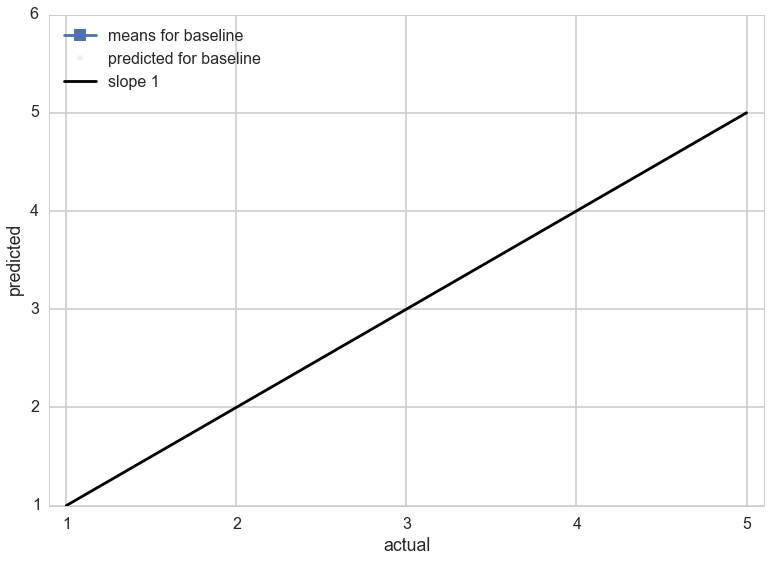

In [72]:
compare_results(y_test, y_ols_pred, model="baseline", predicteds=True)